# import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
#data load
from google.colab import drive
from PIL import Image
import shutil

# Mount Google Drive to /content/drive
drive.mount('/content/drive')

#define dataset paths
lung_dataset_path = '/content/drive/MyDrive/capstone_project /lc25000/lung_image_sets'
colon_dataset_path = '/content/drive/MyDrive/capstone_project /lc25000/colon_image_sets'

print("Lung Dataset:", os.listdir(lung_dataset_path))
print("Colon Dataset:", os.listdir(colon_dataset_path))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lung Dataset: ['lung_n', 'lung_aca', 'lung_scc']
Colon Dataset: ['colon_n', 'colon_aca']


In [ ]:
#check image numbers in each dataset
def check_dataset_enum(dataset_path):
    print(f"Checking dataset at {dataset_path}")
    total_images = 0
    for class_name in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            image_count = len([
                file for file in os.listdir(class_path)
                if file.lower ().endswith(('jpeg'))
            ])
            print(f"Class '{class_name}': {image_count} images")
            total_images += image_count
    print(f"Total images in dataset: {total_images}")



In [ ]:
#check dataset
check_dataset_enum(lung_dataset_path)

Checking dataset at /content/drive/MyDrive/capstone_project /lc25000/lung_image_sets
Class 'lung_aca': 5000 images
Class 'lung_n': 5000 images
Class 'lung_scc': 5000 images
Total images in dataset: 15000


In [ ]:
#check colon
check_dataset_enum(colon_dataset_path)

Checking dataset at /content/drive/MyDrive/capstone_project /lc25000/colon_image_sets
Class 'colon_aca': 5010 images
Class 'colon_n': 5000 images
Total images in dataset: 10010


# Split each dataset into training, validation, testing sets

In [ ]:
import shutil
import random
from pathlib import Path

def split_dataset_copy(dataset_path, output_path, train_ratio = 0.7, val_ratio = 0.15, test_ratio = 0.15, seed=42):
    random.seed(seed)
    dataset_path = Path(dataset_path)
    output_path = Path(output_path)

    #create output folders
    for split in ["train", "val", "test"]:
        for class_dir in os.listdir(dataset_path):
            os.makedirs(output_path / split / class_dir, exist_ok=True)
    #split and copy files
    for class_dir in os.listdir(dataset_path):
        class_path = dataset_path / class_dir
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path / f))]
        random.shuffle(files)

        total = len(files)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        for file_list, split in zip([train_files, val_files, test_files], ["train", "val", "test"]):
            for file_name in file_list:
                src = class_path / file_name
                dst = output_path / split / class_dir / file_name
                shutil.copy(src, dst)

    print(f"Split complete: {dataset_path.name} -> {output_path.name}")


In [ ]:
#split lung datset
split_dataset_copy(
    dataset_path=lung_dataset_path,
    output_path='/content/drive/MyDrive/capstone_project /lc25000/lung_image_sets_split'
)

Split complete: lung_image_sets -> lung_image_sets_split


In [ ]:
#split colon dataset
split_dataset_copy(
    dataset_path=colon_dataset_path,
    output_path='/content/drive/MyDrive/capstone_project /lc25000/colon_image_sets_split'
)

Split complete: colon_image_sets -> colon_image_sets_split


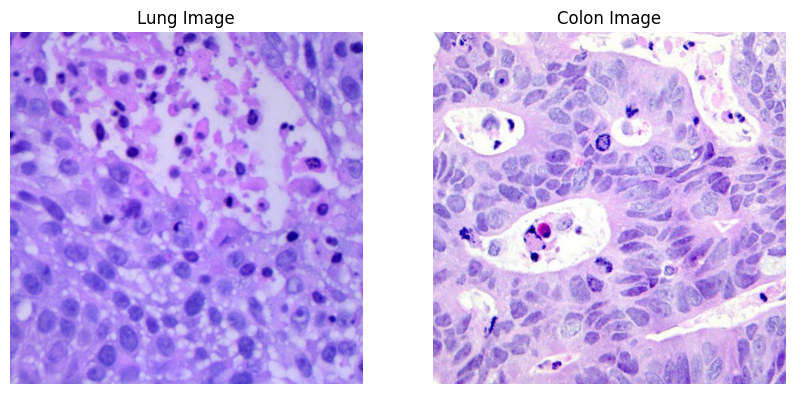

In [ ]:
#select a sample image from lung dataset
lung_class = "lung_scc"
lung_sample_image_path = os.path.join(lung_dataset_path,lung_class, os.listdir(os.path.join(lung_dataset_path, lung_class))[0])

#select a sample image from colon dataset
colon_class = "colon_aca"
colon_sample_image_path = os.path.join(colon_dataset_path, colon_class, os.listdir(os.path.join(colon_dataset_path, colon_class))[0])

#load and display both image
fig, ax = plt.subplots(1,2, figsize=(10,5))

#lung image
lung_img = Image.open(lung_sample_image_path)
ax[0].imshow(lung_img)
ax[0].set_title("Lung Image")
ax[0].axis("off")

#colon image
colon_img = Image.open(colon_sample_image_path)
ax[1].imshow(colon_img)
ax[1].set_title("Colon Image")
ax[1].axis("off")

plt.show()

# Combine and split both


In [ ]:
#combine lung and colon into one folder before splitting
def combine_datset(lung_path, colon_path, combined_output_path):
    os.makedirs(combined_output_path, exist_ok=True)

    for path, label in [(lung_path,"LUNG"), (colon_path, "COLON")]:
        for class_dir in os.listdir(path):
            src_class_path = os.path.join(path, class_dir)
            dst_dir = os.path.join(combined_output_path, class_dir)
            os.makedirs(dst_dir, exist_ok=True)

            for files in os.listdir(src_class_path):
                src_file_path = os.path.join(src_class_path, files)

                #only copy if it's file
                if os.path.isfile(src_file_path):
                    dst_file_path = os.path.join(dst_dir, files)
                    shutil.copy(src_file_path, dst_file_path)
    print(f"Combined dataset created at: {combined_output_path}")





In [ ]:
#combine
combine_datset(
    lung_path=lung_dataset_path,
    colon_path=colon_dataset_path,
    combined_output_path='/content/drive/MyDrive/capstone_project /lc25000/combined_image_sets'
)


Combined dataset created at: /content/drive/MyDrive/capstone_project /lc25000/combined_image_sets


In [ ]:

#create a copy of split combined data
def split_combined_dataset(combined_dataset_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """Splits the combined dataset into train, validation, and test sets.

    Args:
        combined_dataset_path: Path to the combined dataset directory.
        output_path: Path to the output directory where the splits will be saved.
        train_ratio: Proportion of data for the training set.
        val_ratio: Proportion of data for the validation set.
        test_ratio: Proportion of data for the test set.
        seed: Random seed for reproducibility.
    """
    random.seed(seed)

    # Create output directories if they don't exist
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(output_path, split)
        os.makedirs(split_dir, exist_ok=True)
        # Create class subdirectories within each split
        for class_name in os.listdir(combined_dataset_path):
            class_split_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_split_dir, exist_ok=True)


    # Iterate through classes and split images
    for class_name in os.listdir(combined_dataset_path):
        class_path = os.path.join(combined_dataset_path, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)

        total_images = len(images)
        train_end = int(total_images * train_ratio)
        val_end = train_end + int(total_images * val_ratio)

        # Copy images to respective split directories
        for i, image_name in enumerate(images):
            src_path = os.path.join(class_path, image_name)
            if i < train_end:
                dst_path = os.path.join(output_path, "train", class_name, image_name)
            elif i < val_end:
                dst_path = os.path.join(output_path, "val", class_name, image_name)
            else:
                dst_path = os.path.join(output_path, "test", class_name, image_name)
            shutil.copy(src_path, dst_path)

    print(f"Combined dataset split and saved to: {output_path}")


In [ ]:
#split the combined data
split_combined_dataset(
    combined_dataset_path='/content/drive/MyDrive/capstone_project /lc25000/combined_image_sets',
    output_path='/content/drive/MyDrive/capstone_project /lc25000/combined_image_split'
)

Combined dataset split and saved to: /content/drive/MyDrive/capstone_project /lc25000/combined_image_split


In [ ]:
#extract some images from the combined dataset to make sure 5 classes exsited
import matplotlib.image as mpimg
import random
def preview_combined_images(combined_dataset_path, samples_per_class=2):
    class_dirs = os.listdir(combined_dataset_path)

    for class_name in class_dirs:
        class_path = os.path.join(combined_dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        sample_images = random.sample(images, min(samples_per_class, len(images)))

        print(f"Class: {class_name} - showing {len(sample_images)} images")

        plt.figure(figsize=(8, 6))
        for i, image_name in enumerate(sample_images):
            image_path = os.path.join(class_path, image_name)
            img = mpimg.imread(image_path)
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(image_name)
        plt.show()

combined_image_sets_path = '/content/drive/MyDrive/capstone_project /lc25000/combined_image_sets'
preview_combined_images(combined_image_sets_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from itertools import count
#check split folder contents
def check_split_distribution(split_root):
    splits = ["train", "val", "test"]
    for split in splits:
        split_path = os.path.join(split_root, split)
        print(f"{split.upper()}")

        total =0
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            num_images = len(os.listdir(class_path))
            total += num_images
            print(f"Total in {split}: {total} images\n")

In [ ]:
#check lung split
check_split_distribution('/content/drive/MyDrive/capstone_project /lc25000/lung_image_sets_split')


TRAIN
Total in train: 3500 images

Total in train: 7000 images

Total in train: 10500 images

VAL
Total in val: 750 images

Total in val: 1500 images

Total in val: 2250 images

TEST
Total in test: 750 images

Total in test: 1500 images

Total in test: 2250 images



load images into python

In [ ]:
#check colon
check_split_distribution('/content/drive/MyDrive/capstone_project /lc25000/colon_image_sets_split')

TRAIN
Total in train: 3500 images

Total in train: 7007 images

VAL
Total in val: 750 images

Total in val: 1501 images

TEST
Total in test: 750 images

Total in test: 1502 images



In [ ]:
#check combine_split
check_split_distribution('/content/drive/MyDrive/capstone_project /lc25000/combined_image_split')

TRAIN
Total in train: 3500 images

Total in train: 7000 images

Total in train: 10500 images

Total in train: 14000 images

Total in train: 17507 images

VAL
Total in val: 750 images

Total in val: 1500 images

Total in val: 2250 images

Total in val: 3000 images

Total in val: 3751 images

TEST
Total in test: 750 images

Total in test: 1500 images

Total in test: 2250 images

Total in test: 3000 images

Total in test: 3752 images



The total number added up  to 25010, which is correct. that means the data has been split with a ratio of 0.7:0.15:0.15.


# Prepare data for model training

In [ ]:
#create a function to preprocess each dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def preprocess_datasets(base_path,imgsize=(180,180), batch_size=16):
    train_dir = os.path.join(base_path, "train")
    val_dir = os.path.join(base_path, "val")
    test_dir = os.path.join(base_path, "test")

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=imgsize,
        batch_size=batch_size,
        label_mode='categorical'
)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        image_size=imgsize,
        batch_size=batch_size,
        label_mode='categorical'
)
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=imgsize,
        batch_size=batch_size,
        label_mode='categorical'
)
    #store class indices before preprocessing
    class_names = train_ds.class_names

    #normalize pixied value to [0,1]
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds,test_ds, class_names



In [ ]:
#lung dataset
lung_base_path='/content/drive/MyDrive/capstone_project /lc25000/lung_image_sets_split'
lung_train_gen, lung_val_gen, lung_test_gen, lung_class_names = preprocess_datasets(lung_base_path)



Found 10500 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.


In [ ]:
#colon dataset
colon_base_path='/content/drive/MyDrive/capstone_project /lc25000/colon_image_sets_split'
colon_train_gen, colon_val_gen, colon_test_gen, colon_class_names = preprocess_datasets(colon_base_path)

Found 7007 files belonging to 2 classes.
Found 1501 files belonging to 2 classes.
Found 1502 files belonging to 2 classes.


In [ ]:
#combined dataset
combined_base_path='/content/drive/MyDrive/capstone_project /lc25000/combined_image_split'
combined_train_gen, combined_val_gen, combined_test_gen, combined_class_names = preprocess_datasets(combined_base_path)

Found 17507 files belonging to 5 classes.
Found 3751 files belonging to 5 classes.
Found 3752 files belonging to 5 classes.


In [ ]:
#find class names
print(lung_class_names)
print(colon_class_names)
print(combined_class_names)


['lung_aca', 'lung_n', 'lung_scc']
['colon_aca', 'colon_n']
['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [ ]:
#map labels
def extract_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.extend(np.argmax(label.numpy(), axis=1))
    return np.array(labels)

In [ ]:
lung_labels = extract_labels(lung_train_gen)
print(lung_labels[:10])


[1 1 0 1 1 2 1 2 0 1]


In [ ]:
#map to class names
lung_label_names = [lung_class_names[i] for i in lung_labels]
print(lung_label_names[:10])

['lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_n', 'lung_scc', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n']


# Build CNN model for lung dataset

In [ ]:

#define CNN model
model_lung = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

#compile the model
model_lung.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#show model summary
model_lung.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       6,553,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,924,675 (26.42 MB)

 Trainable params: 6,924,675 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train the model
start_time = time.time()
early_stop = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
history_lung = model_lung.fit(
    lung_train_gen,
    epochs=15,
    validation_data=lung_val_gen,
    callbacks=[early_stop],
    verbose=1
)
end_time = time.time()
print(f"Training execution time: {end_time - start_time} seconds")

Epoch 1/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - accuracy: 0.7773 - loss: 0.4834 - val_accuracy: 0.9116 - val_loss: 0.2220
Epoch 2/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.8862 - loss: 0.2798 - val_accuracy: 0.9009 - val_loss: 0.2170
Epoch 3/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9140 - loss: 0.2186 - val_accuracy: 0.9378 - val_loss: 0.1568
Epoch 4/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9278 - loss: 0.1846 - val_accuracy: 0.9449 - val_loss: 0.1624
Epoch 5/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9372 - loss: 0.1630 - val_accuracy: 0.9489 - val_loss: 0.1497
Epoch 6/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9442 - loss: 0.1418 - val_accuracy: 0.9476 - val_loss: 0.1324
Epoch 7/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9608 - loss: 0.1028 - val_accuracy: 0.9582 - val_loss: 0.1256
Epoch 8/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9657 - loss: 0.0957 - v

In [ ]:
#evaluate model performance
def plot_model_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 4))
    #accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    # LOss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


**conclusion**
this CNN model demonstrates strong classification performance with high accuracy and steadily decreasing loss. there is no major overfitting,suggesting a well-balanced model. however, further fine-tuning could help improve generalization further.   ?? increase resolution?

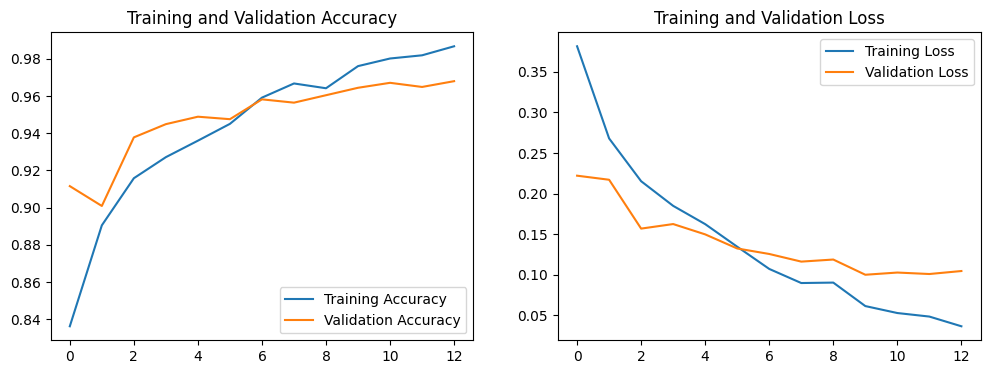

In [ ]:
plot_model_performance(history_lung)

In [ ]:
#test evaluation
test_loss, test_acc = model_lung.evaluate(lung_test_gen)
print(f"Test Accuracy: {test_acc}")


141/141 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9617 - loss: 0.1124
Test Accuracy: 0.9635555744171143


In [ ]:
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, class_names):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.true_labels = []  # To store true labels from the last epoch
        self.pred_labels = []  # To store predicted labels from the last epoch

    def on_epoch_end(self, epoch, logs=None):
        # Get true labels from the validation data
        for images, labels in self.validation_data:
            self.true_labels.extend(np.argmax(labels, axis=1))

        # Make predictions on the validation data
        predictions = self.model.predict(self.validation_data)
        self.pred_labels = np.argmax(predictions, axis=1)

        # Reset true_labels and pred_labels for the next epoch
        self.true_labels = []
        self.pred_labels = []

    def on_train_end(self, logs=None):
        # Calculate and plot the confusion matrix after training ends
        cm = confusion_matrix(y_true=self.true_labels, y_pred=self.pred_labels)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix for the Last Epoch')
        plt.tight_layout()
        plt.show()

In [ ]:

def plot_confusion_matrix(model, test_generator, class_names, title='Confusion matrix'):
    #true labels
    true_labels = []
    images_list = []  # Store all images in a list

    for images, labels in test_generator:
        true_labels.extend(np.argmax(labels, axis=1))
        images_list.extend(images.numpy())  # Extend with NumPy array of images

    #get predictions
    predictions = model.predict(np.array(images_list))  # Predict on the entire dataset
    pred_labels = np.argmax(predictions, axis=1)

    #confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    report = classification_report(true_labels, pred_labels, target_names=class_names)
    print(report)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


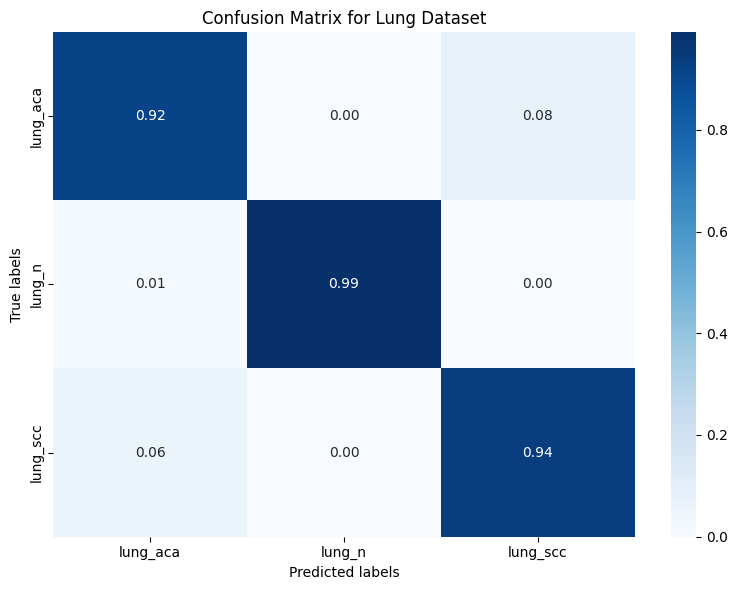


Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.93      0.92      0.92       750
      lung_n       1.00      0.99      0.99       750
    lung_scc       0.92      0.94      0.93       750

    accuracy                           0.95      2250
   macro avg       0.95      0.95      0.95      2250
weighted avg       0.95      0.95      0.95      2250



In [ ]:
#confusion matrix for lung dataset
plot_confusion_matrix(model_lung, lung_test_gen, lung_class_names, title='Confusion Matrix for Lung Dataset')

# Train model for colon dataset

In [ ]:
model_colon = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='sigmoid')  # Assuming 2 classes (0 and 1)
])

In [ ]:
#compile model
model_colon.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#show model summary
model_colon.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 102400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       6,553,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,924,610 (26.42 MB)

 Trainable params: 6,924,610 (26.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train colon dataet
time_start = time.time()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_colon = model_colon.fit(
    colon_train_gen,
    epochs=15,
    callbacks=[early_stop],
    validation_data=colon_val_gen,
    verbose=1
)
time_end = time.time()
print(f"Training execution time: {time_end - time_start} seconds")


Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 646s 1s/step - accuracy: 0.5869 - loss: 0.6550 - val_accuracy: 0.5836 - val_loss: 0.6483
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.7912 - loss: 0.4337 - val_accuracy: 0.8574 - val_loss: 0.3243
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8596 - loss: 0.3248 - val_accuracy: 0.9061 - val_loss: 0.2372
Epoch 4/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.8971 - loss: 0.2594 - val_accuracy: 0.9354 - val_loss: 0.1643
Epoch 5/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9271 - loss: 0.1885 - val_accuracy: 0.9440 - val_loss: 0.1563
Epoch 6/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9477 - loss: 0.1453 - val_accuracy: 0.9674 - val_loss: 0.1001
Epoch 7/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9524 - loss: 0.1222 - val_accuracy: 0.9647 - val_loss: 0.1137
Epoch 8/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9638 - loss: 0.1133 - v

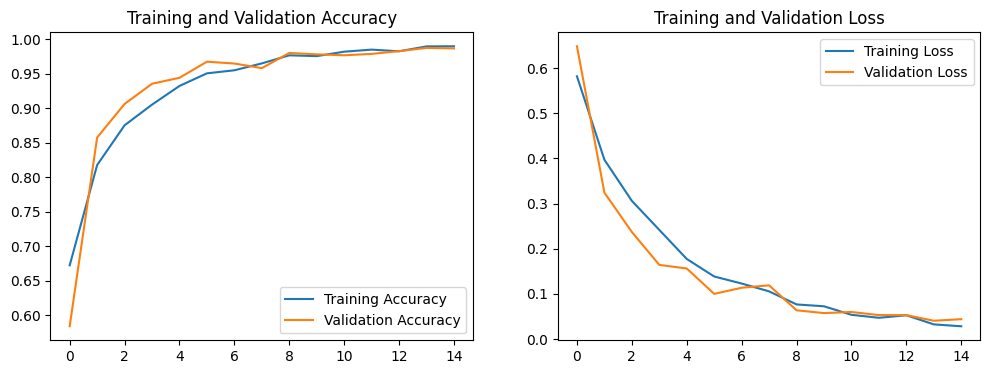

In [ ]:
#evaluate model
plot_model_performance(history_colon)


In [ ]:
#evaluate the test
test_loss, test_acc = model_colon.evaluate(colon_test_gen)
print(f"Test Accuracy: {test_acc}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9852 - loss: 0.0556
Test Accuracy: 0.9880159497261047


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step


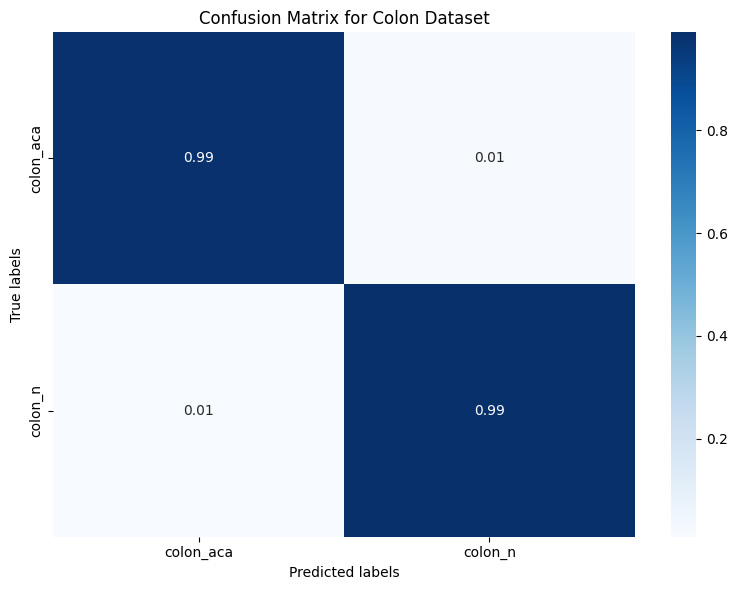


Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.99      0.99      0.99       752
     colon_n       0.99      0.99      0.99       750

    accuracy                           0.99      1502
   macro avg       0.99      0.99      0.99      1502
weighted avg       0.99      0.99      0.99      1502



In [ ]:
#confusion matrix
plot_confusion_matrix(model_colon, colon_test_gen, colon_class_names, title='Confusion Matrix for Colon Dataset')


# train the combined model


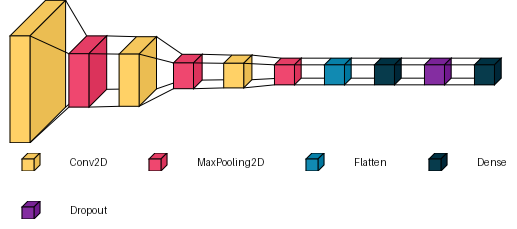

In [ ]:
#build modle and visualize the model
!pip install -q visualkeras
import visualkeras
from tensorflow.keras.utils import plot_model
from PIL import ImageFont
model_combined = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 output neurons for 5 classes
])
try:
    font = ImageFont.truetype("arial.ttf", 12)
except:
    font = None
visualkeras.layered_view(
    model_combined,
    legend=True,
    spacing=30,
    scale_xy=0.6,
    scale_z=0
)





In [ ]:
#compile the model
model_combined.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_combined.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 178, 178, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 89, 89, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 87, 87, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 41, 41, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,014,789 (7.69 MB)

 Trainable params: 2,014,789 (7.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train the model
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint
time_start = time.time()
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callbacks = [early_stop, checkpoint]
history_combined = model_combined.fit(
    combined_train_gen,
    epochs=15,
    validation_data=combined_val_gen,
    callbacks=callbacks,
    verbose=1
)
time_end = time.time()
print(f"Training execution time: {time_end - time_start} seconds")

Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5145 - loss: 1.0648
Epoch 1: val_loss improved from inf to 0.44863, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 1994s 2s/step - accuracy: 0.5146 - loss: 1.0646 - val_accuracy: 0.8014 - val_loss: 0.4486
Epoch 2/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7874 - loss: 0.5232
Epoch 2: val_loss improved from 0.44863 to 0.29000, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.7874 - loss: 0.5231 - val_accuracy: 0.8888 - val_loss: 0.2900
Epoch 3/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8386 - loss: 0.3902
Epoch 3: val_loss improved from 0.29000 to 0.24515, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.8387 - loss: 0.3902 - val_accuracy: 0.9019 - val_loss: 0.2452
Epoch 4/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8748 - loss: 0.3193
Epoch 4: val_loss improved from 0.24515 to 0.19459, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.8748 - loss: 0.3193 - val_accuracy: 0.9286 - val_loss: 0.1946
Epoch 5/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8992 - loss: 0.2645
Epoch 5: val_loss improved from 0.19459 to 0.16674, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.8992 - loss: 0.2645 - val_accuracy: 0.9416 - val_loss: 0.1667
Epoch 6/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9052 - loss: 0.2446
Epoch 6: val_loss did not improve from 0.16674
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9052 - loss: 0.2446 - val_accuracy: 0.9347 - val_loss: 0.1832
Epoch 7/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9203 - loss: 0.2113
Epoch 7: val_loss did not improve from 0.16674
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9203 - loss: 0.2112 - val_accuracy: 0.9366 - val_loss: 0.1755
Epoch 8/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9307 - loss: 0.1742
Epoch 8: val_loss improved from 0.16674 to 0.12974, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9307 - loss: 0.1742 - val_accuracy: 0.9536 - val_loss: 0.1297
Epoch 9/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9380 - loss: 0.1682
Epoch 9: val_loss did not improve from 0.12974
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9380 - loss: 0.1682 - val_accuracy: 0.9536 - val_loss: 0.1367
Epoch 10/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9427 - loss: 0.1526
Epoch 10: val_loss did not improve from 0.12974
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9427 - loss: 0.1525 - val_accuracy: 0.9480 - val_loss: 0.1613
Epoch 11/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9450 - loss: 0.1437
Epoch 11: val_loss improved from 0.12974 to 0.12858, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9450 - loss: 0.1438 - val_accuracy: 0.9571 - val_loss: 0.1286
Epoch 12/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9537 - loss: 0.1264
Epoch 12: val_loss did not improve from 0.12858
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9537 - loss: 0.1264 - val_accuracy: 0.9568 - val_loss: 0.1308
Epoch 13/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9557 - loss: 0.1188
Epoch 13: val_loss did not improve from 0.12858
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9557 - loss: 0.1188 - val_accuracy: 0.9413 - val_loss: 0.1744
Epoch 14/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9562 - loss: 0.1119
Epoch 14: val_loss improved from 0.12858 to 0.11115, saving model to best_model.h5


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9562 - loss: 0.1119 - val_accuracy: 0.9651 - val_loss: 0.1112
Epoch 15/15
1094/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9639 - loss: 0.0918
Epoch 15: val_loss did not improve from 0.11115
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - accuracy: 0.9639 - loss: 0.0918 - val_accuracy: 0.9443 - val_loss: 0.1585
Training execution time: 3131.9137513637543 seconds


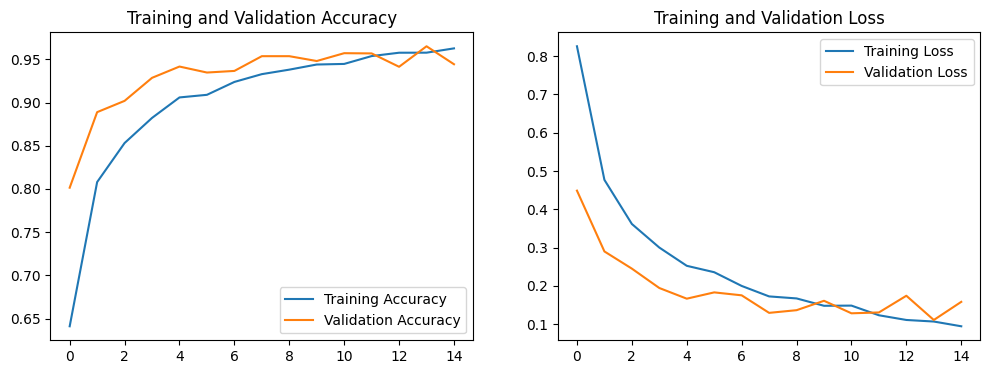

In [ ]:
#evaluate model performance
plot_model_performance(history_combined)


In [ ]:
#test evaluation
test_loss, test_acc = model_combined.evaluate(combined_test_gen)
print(f"Test Accuracy: {test_acc}")


235/235 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.9620 - loss: 0.1445
Test Accuracy: 0.9610874056816101


118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step


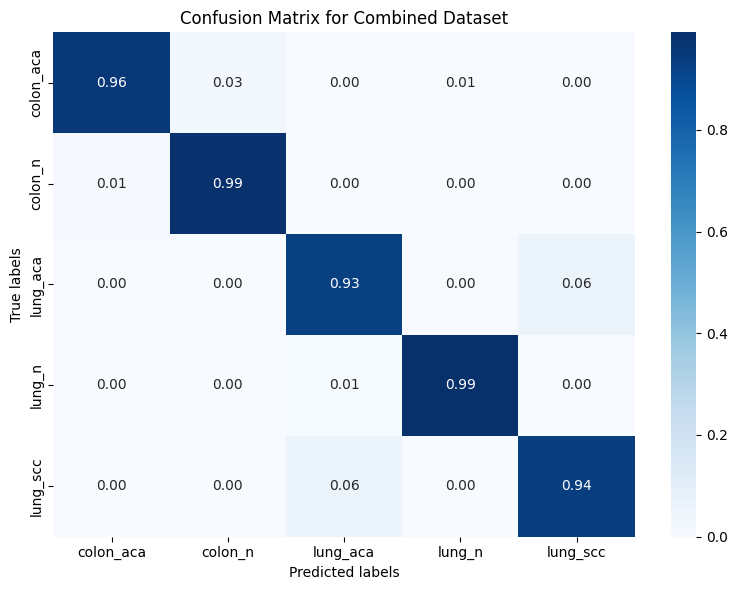


Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.98      0.96      0.97       752
     colon_n       0.96      0.99      0.97       750
    lung_aca       0.93      0.93      0.93       750
      lung_n       0.99      0.99      0.99       750
    lung_scc       0.94      0.94      0.94       750

    accuracy                           0.96      3752
   macro avg       0.96      0.96      0.96      3752
weighted avg       0.96      0.96      0.96      3752



In [ ]:
#confusion matrix and classification report
plot_confusion_matrix(model_combined, combined_test_gen, combined_class_names, title='Confusion Matrix for Combined Dataset')



In [ ]:
#save the model for deployment
model_combined.save("combined_model.h5")


create app.py


In [ ]:
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
!pip install streamlit
import numpy as np
import matplotlib.pyplot as plt
#load model
model = load_model("best_model.h5")
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

#app title
st.title("Lung and colon cancer histopathology classifier")
#file uploader
uploaded_file = st.file_uploader("Upload histopathological images", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    img = img.resize((180, 180))
    st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)

    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    #prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    confidence = float(np.max(prediction))

    st.markdown(f"**Prediction:** {class_names[predicted_class_index]}")
    st.markdown(f"**Confidence:** {confidence * 100:.2f}%")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
# dont worry about the above code script, you can just ignore it :)

# use pretrained model to compare results

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

In [ ]:
# ResNet50

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(280, 280, 3))

# unfreeze the last 30 layers for fine_tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
# Add a fully-connected layer for classification
predictions = Dense(5, activation='softmax', kernel_regularizer=l2(0.001))(x)  # 5 classes for combined dataset

# Create the fine-tuned model
model_pretrained = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_pretrained.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
#call backs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
time_start = time.time()
# Train the model on combined data
history_pretrained = model_pretrained.fit(
    combined_train_gen,
    validation_data=combined_val_gen,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
time_end = time.time()
print(f"Training execution time: {time_end - time_start} seconds")

Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 178s 146ms/step - accuracy: 0.5908 - loss: 1.2576 - val_accuracy: 0.8134 - val_loss: 0.7984 - learning_rate: 1.0000e-04
Epoch 2/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.8035 - loss: 0.7612 - val_accuracy: 0.4943 - val_loss: 1.7900 - learning_rate: 1.0000e-04
Epoch 3/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.8372 - loss: 0.6783 - val_accuracy: 0.8579 - val_loss: 0.6225 - learning_rate: 1.0000e-04
Epoch 4/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.8562 - loss: 0.6164 - val_accuracy: 0.6577 - val_loss: 1.0909 - learning_rate: 1.0000e-04
Epoch 5/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.8757 - loss: 0.5668 - val_accuracy: 0.7969 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 6/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 126s 115ms/step - accuracy: 0.9008 - loss: 0.5080 - val_accuracy: 0.9088 - val_loss: 0.4776 - learning_rate: 2.0000e-05
Epoch 7/15
1095/1095 ━━━━━━━

In [ ]:
#test evaluate
test_loss, test_acc = model_pretrained.evaluate(combined_test_gen)
print(f"Test Accuracy: {test_acc}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.9386 - loss: 0.4064
Test Accuracy: 0.9440298676490784


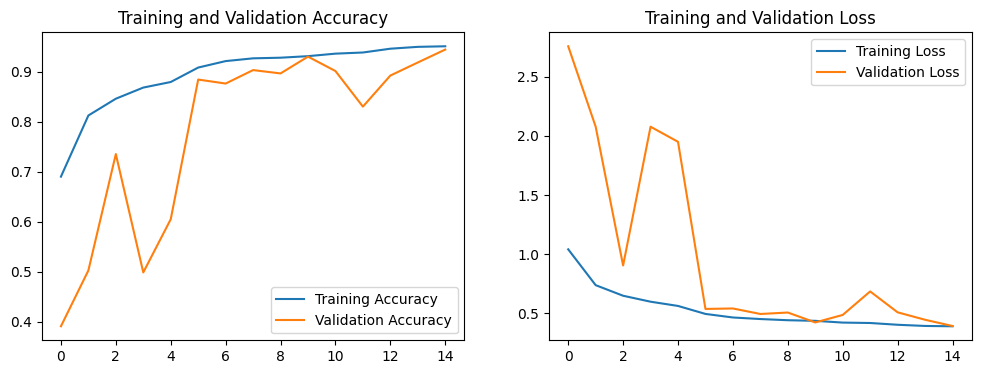

In [ ]:
#evaluate resolution 224
plot_model_performance(history_pretrained)


118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 179ms/step


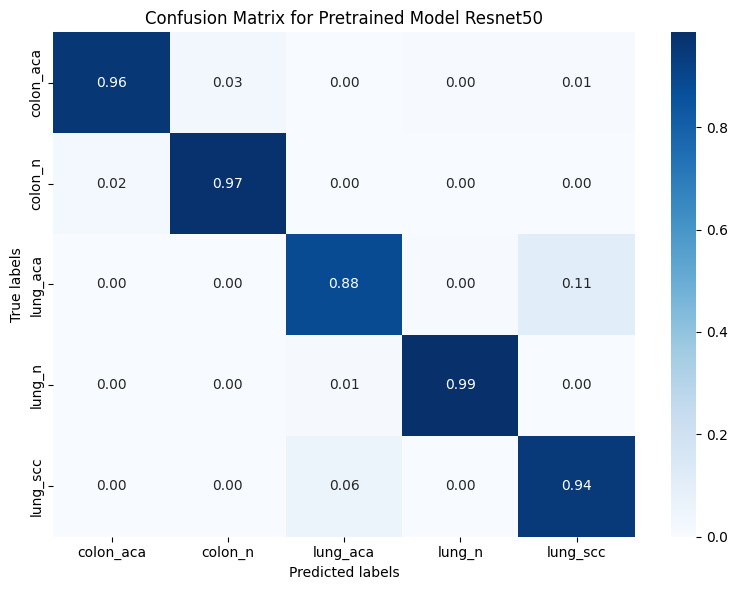


Classification Report:
              precision    recall  f1-score   support

   colon_aca       0.97      0.96      0.97       752
     colon_n       0.97      0.97      0.97       750
    lung_aca       0.92      0.88      0.90       750
      lung_n       0.99      0.99      0.99       750
    lung_scc       0.89      0.94      0.92       750

    accuracy                           0.95      3752
   macro avg       0.95      0.95      0.95      3752
weighted avg       0.95      0.95      0.95      3752



In [ ]:
#confusion matrix
plot_confusion_matrix(model_pretrained, combined_test_gen, combined_class_names, title='Confusion Matrix for Pretrained Model Resnet50')

In [ ]:
model_pretrained.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 280, 280, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 286, 286, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 140, 140, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 140, 140, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 140, 140, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 142, 142, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 70, 70, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 70, 70, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 70, 70, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 70, 70, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 70, 70, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 70, 70, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 70, 70, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 70, 70, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 70, 70, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 38,563,724 (147.11 MB)

 Trainable params: 14,713,093 (56.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

 Optimizer params: 14,713,095 (56.13 MB)

#  pretrained model-DenseNet121





In [ ]:
from tensorflow.keras.applications import DenseNet121
base_model_2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(280, 280, 3))
base_model_2.trainable = False

x = GlobalAveragePooling2D()(base_model_2.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
prediction_den = Dense(5, activation='softmax', kernel_regularizer=l2(0.001))(x)

model_den = Model(inputs=base_model_2.input, outputs=prediction_den)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
#compile the model
model_den.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
#callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)


In [ ]:
model_den.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 280, 280, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 286, 286, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 140, 140, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 140, 140, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 140, 140, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 142, 142, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 70, 70, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 70, 70, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 70, 70, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 70, 70, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 70, 70, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 70, 70, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 70, 70, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 70, 70, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,169,349 (27.35 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
#train the model
time_start = time.time()
history_den = model_den.fit(
    combined_train_gen,
    validation_data=combined_val_gen,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
time_end = time.time()
print(f"Training execution time: {time_end - time_start} seconds")


Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.7397 - loss: 0.9490 - val_accuracy: 0.9584 - val_loss: 0.2598 - learning_rate: 1.0000e-04
Epoch 2/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 79s 72ms/step - accuracy: 0.9428 - loss: 0.2850 - val_accuracy: 0.9661 - val_loss: 0.1991 - learning_rate: 1.0000e-04
Epoch 3/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9573 - loss: 0.2207 - val_accuracy: 0.9763 - val_loss: 0.1676 - learning_rate: 1.0000e-04
Epoch 4/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9684 - loss: 0.1847 - val_accuracy: 0.9803 - val_loss: 0.1468 - learning_rate: 1.0000e-04
Epoch 5/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9736 - loss: 0.1629 - val_accuracy: 0.9829 - val_loss: 0.1320 - learning_rate: 1.0000e-04
Epoch 6/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9735 - loss: 0.1484 - val_accuracy: 0.9829 - val_loss: 0.1221 - learning_rate: 1.0000e-04
Epoch 7/15
1095/1095 ━━━━━━━━━━━━━━━━━━

In [ ]:
#test evaluate
test_loss, test_acc = model_den.evaluate(combined_test_gen)
print(f"Test Accuracy: {test_acc}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.9895 - loss: 0.0900
Test Accuracy: 0.9890725016593933


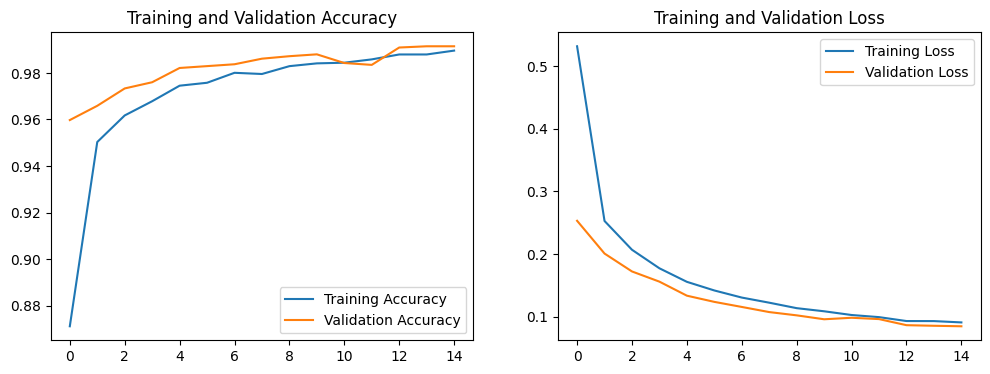

In [ ]:
#model performance
plot_model_performance(history_den)

118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step


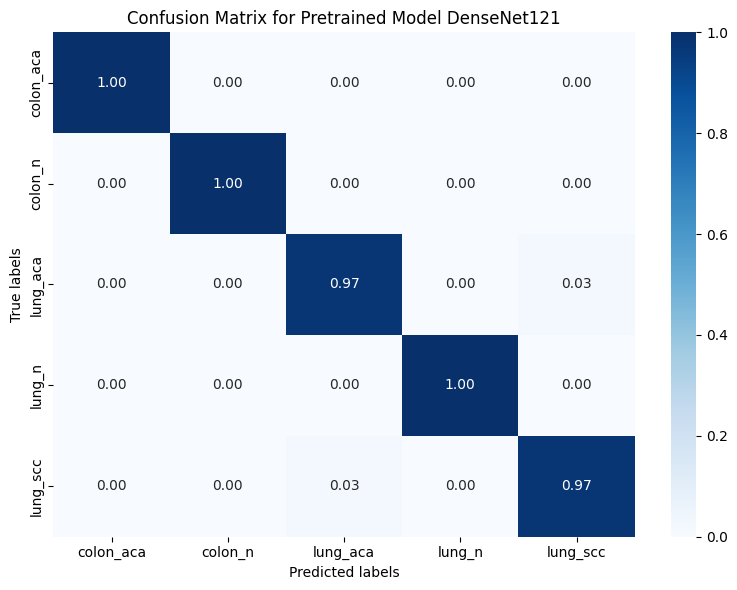


Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       752
     colon_n       1.00      1.00      1.00       750
    lung_aca       0.97      0.97      0.97       750
      lung_n       1.00      1.00      1.00       750
    lung_scc       0.97      0.97      0.97       750

    accuracy                           0.99      3752
   macro avg       0.99      0.99      0.99      3752
weighted avg       0.99      0.99      0.99      3752



In [ ]:
#confusion matrix and report
plot_confusion_matrix(model_den, combined_test_gen, combined_class_names, title='Confusion Matrix for Pretrained Model DenseNet121')

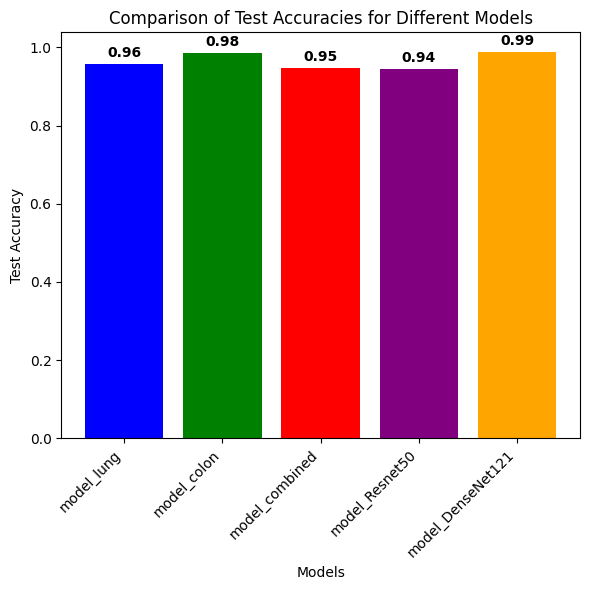

In [ ]:
#test accuracy bar chart
# Assume you have the following test accuracies for different models:
model_names = ['model_lung', 'model_colon', 'model_combined', 'model_Resnet50', 'model_DenseNet121']
test_accuracies = [0.957, 0.985, 0.948, 0.944, 0.989]  # Replace with your actual accuracies

# Create the bar chart
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.bar(model_names, test_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies for Different Models')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment if needed

# Display the accuracy values on top of the bars
for i, v in enumerate(test_accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

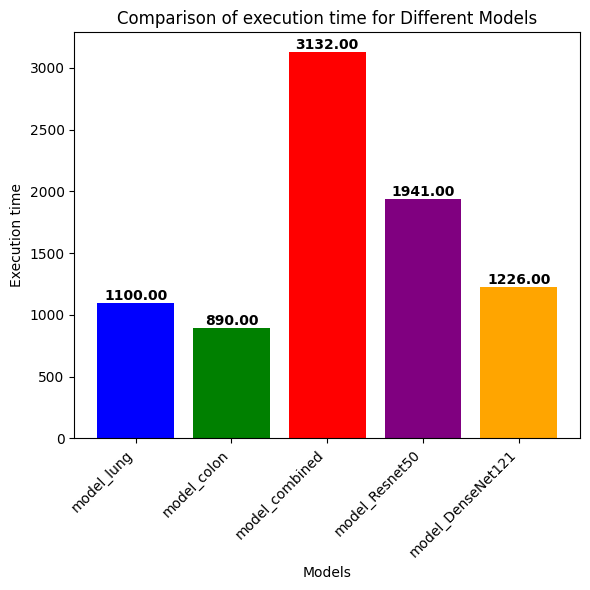

In [ ]:
# execution time bar chart
model_names = ['model_lung', 'model_colon', 'model_combined', 'model_Resnet50', 'model_DenseNet121']
execution_time = [1100, 890, 3132, 1941, 1226]

# Create the bar chart
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
plt.bar(model_names, execution_time, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Execution time')
plt.title('Comparison of execution time for Different Models')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment if needed

# Display the accuracy values on top of the bars
for i, v in enumerate(execution_time):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()